# $$\text{Espaço de Estados - Questão 2:}$$ 

##### $$\text{Erick e Robson}$$

In [1]:
import numpy as np
import control as ct
import matplotlib.pyplot as plt
import scienceplots

#Configurações de plot:
plt.style.use([
    'grid',
    'retro'
])
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = (10, 8)
colors = ['C0', 'C1', 'C2', 'C4', 'C5', 'y']

### $$\text{Definição do sistema:}$$

In [2]:
s = ct.tf('s')

G = (((2*s)+1)/((s**3)+3))

G

TransferFunction(array([2, 1]), array([1, 0, 0, 3]))

### $$\text{Espaço de estados canônico:}$$

In [3]:
sys = ct.tf2ss(G)

n = len(sys.A)
A = np.empty((n, n))
for i in range(n):
    for j in range(n):
        A[n-1-i][n-1-j] = sys.A[i][j]

B = np.empty((n, 1))
for i in range(n):
    B[n-1-i][0] = sys.B[i][0]

C = np.empty(n)
for i in range(n):
    C[n-1-i] = sys.C[0][i]

D = np.array([0])

ct.ss(A, B, C, D)

StateSpace(array([[ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [-3., -0., -0.]]), array([[0.],
       [0.],
       [1.]]), array([[1., 2., 0.]]), array([[0.]]))

In [4]:
ct.poles(G)

array([-1.44224957+0.j        ,  0.72112479+1.24902477j,
        0.72112479-1.24902477j])

In [5]:
ct.zeros(G)

array([-0.5+0.j])

### $$\text{Calculando os polos desejados para atender às especificações:}$$

In [6]:
#Cálculo do coeficiente de amortecimento desejado:
os = 0.08
zeta = (-np.log(os)/np.sqrt((np.pi**2)+(np.log(os)**2)))
print(f'zeta: {zeta}')

#Cálculo da frequência natural desejada:
ST = 2
wn = (4/(zeta*ST))
print(f'wn: {wn}')

#Par complexo que deseja-se ser o dominante:
pcomp = complex(-(zeta*wn), (wn*np.sqrt(1-(zeta**2))))

pcomp

zeta: 0.6265771868559205
wn: 3.191945129754451


(-2+2.4876723480722216j)

In [7]:
# Serão 4 polos em malha fechada: um par complexo que deseja-se ser o dominante, 
# mais um do sistema e um do integrador, que deseja-se alocar de forma a não interferir na dinâmica.

#Alocando um polo para cancelar o zero do sistema:
pz = ct.zeros(G)[0].real
print(f'pz: {pz}')


#Alocando um polo uma década a baixo dos polos dominantes:
pnd = (pcomp.real*10)
print(f'pnd: {pnd}')

#Os polos a serem alocados serão, portanto:
pd = np.array([pz, pnd, pcomp], dtype=np.complex_)

pd

pz: -0.5
pnd: -20.0


array([ -0.5+0.j        , -20. +0.j        ,  -2. +2.48767235j])

### $$\text{Projeto dos ganhos do PI-like:}$$

In [8]:
#Definição das matrizes aumentadas:
Atil = np.block([[A, np.zeros((len(A),1))], [-C, np.array([0])]])
Btil = np.vstack((B, np.array([0])))
print(f'Atil: {Atil}')
print(f'Btil: {Btil}')

#Organizando os polos na matriz modal:
modals = []
order = 0
for i in range(len(pd)):
    if(pd[i].imag == 0):
        modals.append([pd[i].real])
        order += 1
    else:
        modals.append([pd[i].real, pd[i].imag])
        order += 2
F = np.zeros((order, order))
for i in range(len(modals)):
    if(len(modals[i])==1):
        F[i][i] = modals[i][0]
    else:
        F[i][i] = modals[i][0]
        F[i][i+1] = -modals[i][1]
        F[i+1][i] = modals[i][1]
        F[i+1][i+1] = modals[i][0]
print(f'F: {F}')

#Arbitrar ktil:
ktil = np.ones(len(Atil))
print(f'ktil: {ktil}')

#Encontrar a matriz de transformação de base:
T = ct.lyap(Atil, -F, -Btil*ktil)
print(f'T: {T}')

k = ktil@np.linalg.inv(T)

k

Atil: [[ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [-3. -0. -0.  0.]
 [-1. -2. -0.  0.]]
Btil: [[0.]
 [0.]
 [1.]
 [0.]]
F: [[ -0.5          0.           0.           0.        ]
 [  0.         -20.           0.           0.        ]
 [  0.           0.          -2.          -2.48767235]
 [  0.           0.           2.48767235  -2.        ]]
ktil: [1. 1. 1. 1.]
T: [[-3.47826087e-01  1.25046893e-04 -1.42370045e-02 -3.75283165e-02]
 [ 1.73913043e-01 -2.50093785e-03 -6.48841462e-02  1.10473635e-01]
 [-8.69565217e-02  5.00187570e-02  4.04590500e-01 -5.95367742e-02]
 [-9.99200722e-16 -2.43841441e-04  1.65162134e-02  7.11660134e-02]]


array([  42.09425686,  102.18851371,   24.5       , -101.88513711])

### $$\text{Interconexão da malha fechada:}$$

In [9]:
#Sistema:
stateslabels = ['y']
for i in range(len(A)):
    stateslabels.append(f'x{i+1}')
G = ct.ss(A,B,np.vstack((C, np.identity(len(A)))),np.zeros((len(A)+1, 1)), inputs=['u'], outputs=stateslabels)

#Somador que gera o sinal de erro:
some = ct.summing_junction(inputs=['r', '-y'], output='e')

#Realimentação dos estados:
K = []
kxl = []
for i in range(len(k)-1):
    current_kxl = f'kx{i+1}'
    K.append(ct.tf((-k[i]), (1), inputs=f'x{i+1}', outputs=current_kxl))
    kxl.append(current_kxl)

#Ramo integrador:
Gi = ct.tf([1], [1, 0], inputs='e', outputs='xa')
ka = ct.tf((-k[-1]), (1), inputs='xa', outputs='kaxa')
kxl.append('kaxa')

#Adicionando a entrada de perturbação:
kxl.append('d')

#Somador que gera o sinal de controle:
somu = ct.summing_junction(inputs=kxl, output='u')

#Interconnect:
componentes = [G, Gi, ka, somu, some]
componentes.extend(K)
out = ['u']
out.extend(stateslabels)
out.append('xa')
L = ct.interconnect(componentes, inputs=['r', 'd'], outputs=out)

In [10]:
ct.poles(L)

array([-20. +0.j        ,  -2. +2.48767235j,  -2. -2.48767235j,
        -0.5+0.j        ])

### $$\text{Simulação do sistema:}$$

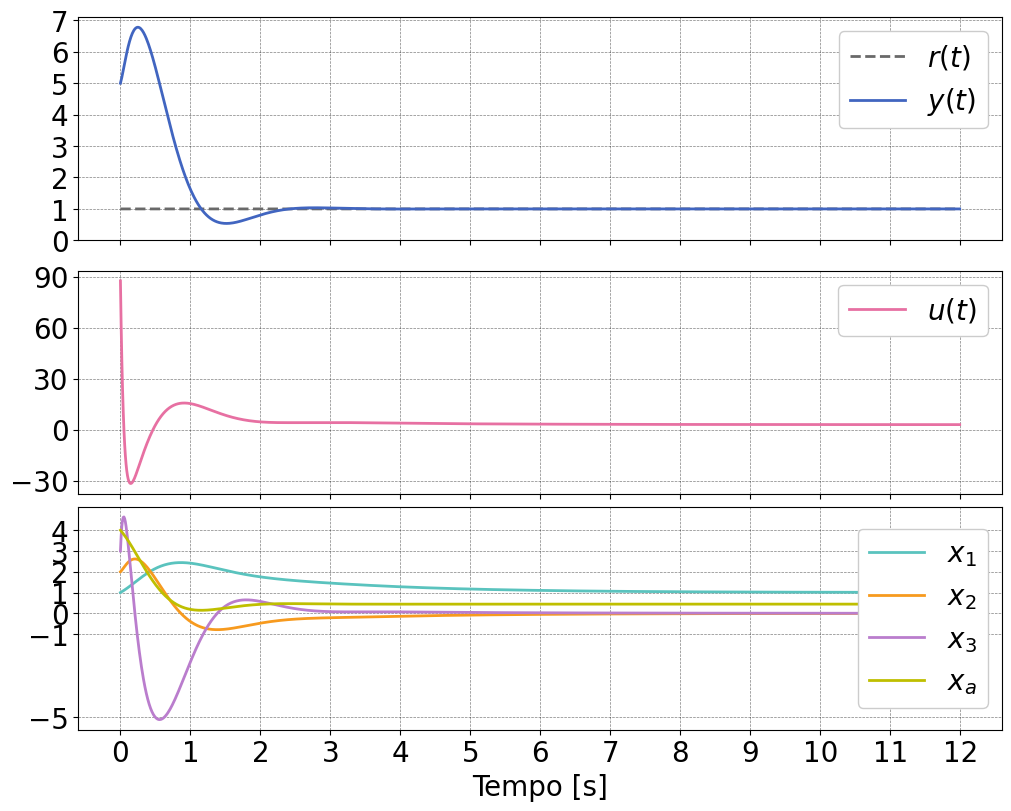

In [11]:
#Vetor de tempo:
ts = 1e-2
tdeg = 12
t = np.arange(0, 1*tdeg, ts)

#Vetor de referência:
r = np.hstack([np.ones(int(tdeg/ts))])

#, np.ones(int(tdeg/ts))*-30

#Perturbação no sistema
d = np.hstack([np.zeros(int(tdeg/ts))])

#Simulação do sistema:
t, sol = ct.forced_response(L, t, [r, d], X0=[1, 2, 3, 4])

#Demultiplex da saída:
u = sol[0]
y = sol[1]
x = sol[2:]

#Plot das curvas:
labels = []
for i in range(len(x)-1):
    labels.append(f'$x_{i+1}$')
labels.append('$x_a$')
plt.subplots(3, 1, sharex=True, constrained_layout = True)
plt.subplot(3, 1, 1)
plt.plot(t, r, color='C3', linestyle='dashed', label='$r(t)$')
plt.plot(t, y, color='C0', label='$y(t)$')
plt.yticks(range(7+1))
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(t, u, color='C1', label='$u(t)$')
plt.yticks([-30, 0, 30, 60, 90])
plt.legend()
plt.subplot(3, 1, 3)
for i in range(len(x)):
    plt.plot(t, x[i], color=colors[i+2], label=labels[i])
plt.xlabel('Tempo [s]')
plt.yticks([-5, -1, 0, 1, 2, 3, 4])
plt.xticks(range(tdeg+1))
plt.legend(loc='center right')
plt.show()

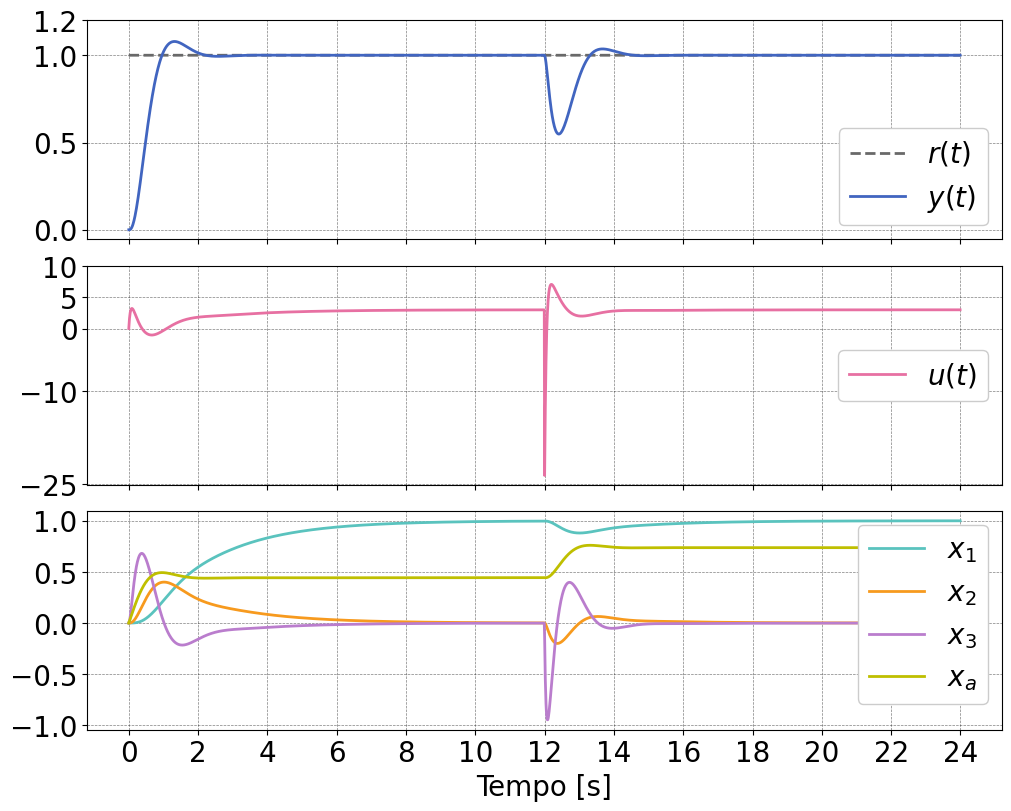

In [12]:
#Vetor de tempo:
ts = 1e-2
tdeg = 12
t = np.arange(0, 2*tdeg, ts)

#Vetor de referência:
r = np.hstack([np.ones(int(tdeg/ts)), np.ones(int(tdeg/ts))])

#, np.ones(int(tdeg/ts))*-30

#Perturbação no sistema
d = np.hstack([np.zeros(int(tdeg/ts)), np.ones(int(tdeg/ts))*-30])

#Simulação do sistema:
t, sol = ct.forced_response(L, t, [r, d], X0=[0, 0, 0, 0])

#Demultiplex da saída:
u = sol[0]
y = sol[1]
x = sol[2:]

#Plot das curvas:
labels = []
for i in range(len(x)-1):
    labels.append(f'$x_{i+1}$')
labels.append('$x_a$')
plt.subplots(3, 1, sharex=True, constrained_layout = True)
plt.subplot(3, 1, 1)
plt.plot(t, r, color='C3', linestyle='dashed', label='$r(t)$')
plt.plot(t, y, color='C0', label='$y(t)$')
plt.yticks([0, 0.5, 1.0, 1.2])
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(t, u, color='C1', label='$u(t)$')
plt.yticks([-25, -10, 0, 5, 10])
plt.legend(loc='center right')
plt.subplot(3, 1, 3)
for i in range(len(x)):
    plt.plot(t, x[i], color=colors[i+2], label=labels[i])
plt.xlabel('Tempo [s]')
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.legend()
plt.xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24])
plt.show()

In [13]:
np.max(y)

1.0788459874006868